## Project 9

**Mohammad Kamal Sadeghabadi Farahani**

### Description

In this project we have implemented convolutional and pooling connections then we will use a filter as the kernel of covolutional connection and then use a pooling connection at last layer.

In [38]:
import torch
import sys
import copy
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

sys.path.insert(0, '../../')

from cnsproject.imagetools.filters import DoG, gabor, convolve
from cnsproject.encoding.encoders import Time2FirstSpikeEncoder
from cnsproject.plotting.plotting import raster_plot
from cnsproject.network.neural_populations import InputPopulation, LIFPopulation
from cnsproject.network.connections import ConvolutionalConnection, PoolingConnection, calculate_pooling_post_population_size

img_size = (64, 64)
img = Image.open('./images/img.png')
img_tensor = torch.tensor(np.asarray(img.convert('RGB').convert('L').resize(img_size)))

### Convolutional connections

In [65]:
def simulate_convolutional_connection(time, kernel):
    dt = 0.001
    encoder = Time2FirstSpikeEncoder(time, dt)
    coded = encoder(0, 255, img_tensor)
    
    print('Image:')
    plt.imshow(img_tensor, cmap='gray')
    plt.show()
    
    print('Kernel:')
    plt.imshow(kernel, cmap='gray')
    plt.show()
    
    input_pop = InputPopulation(shape=img_tensor.shape)
    output_pop = LIFPopulation(
        shape=(img_tensor.shape[0] - kernel.shape[0] + 1, img_tensor.shape[1] - kernel.shape[1] + 1),
        tau=0.1, rest_potential=-60, threshold=-59.5)
    
    conv_synapse = ConvolutionalConnection(pre=input_pop, post=output_pop, kernel=kernel)
    
    steps = int(time / dt)
    
    spikes = []
    for i in range(steps):
        input_pop.forward(coded[i], spike_effects=None)
        spike_effects = conv_synapse.compute(input_pop.s)
        output_pop.forward(torch.zeros(output_pop.shape), spike_effects)
        spikes.append(output_pop.s)
    
    raster_plot([spikes], dt)

### Experiment 1

Image:


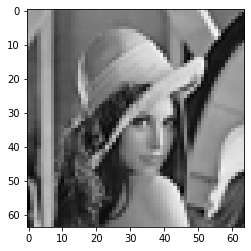

Kernel:


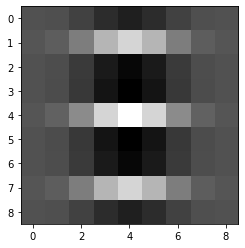

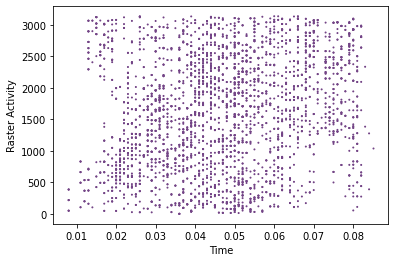

In [69]:
kernel = gabor(lambda_=3, theta=np.pi, sigma=4, gamma=3, size=9)
simulate_convolutional_connection(0.1, kernel)

### Analysis of experiment 1

| kernel | $\lambda$ | $\theta$ | $\sigma$ | $\gamma$ | size |
| ------ | --------- | -------- | -------- | -------- | ---- |
| Gabor |      3    |  $\pi$   |    4     |     3    |   9  |

Here we have used a gabor filter that identifies horizontal lines as our kernel, as we can see with the raster plot the neruons that represent bold horizontal lines will spike faster than the neurons that represent fade horizontal lines.

### Experiment 2

Image:


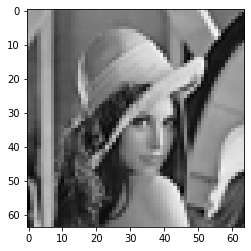

Kernel:


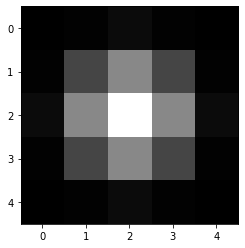

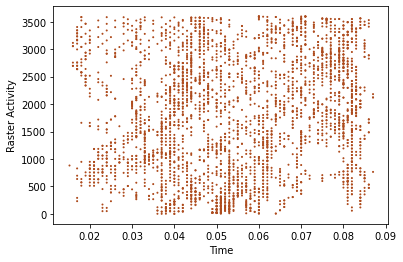

In [67]:
kernel = DoG(std_1=1, std_2=3, size=5)
simulate_convolutional_connection(0.1, kernel)

### Analysis of experiment 2

| kernel | $\sigma_1$ | $\sigma_2$ | size |
| ------ | ---------- | ---------- | ---- |
|   DoG  |      1     |     3      |  5   |


Here we have used a DoG filter, as we know DoG filter is used to recognize bright point in a dark background, so here the neurons that represent a brighter point in a dark background will spike faster than less bright points in a dark background.

### Convolutional and Pooling connections

In [70]:
def simulate_convolutional_and_pooling_connections(time, kernel, pooling_size, pooling_stride):
    dt = 0.001
    
    encoder = Time2FirstSpikeEncoder(time, dt)
    coded = encoder(0, 255, img_tensor)
    
    print('Image:')
    plt.imshow(img_tensor, cmap='gray')
    plt.show()
    
    print('Kernel:')
    plt.imshow(kernel, cmap='gray')
    plt.show()
    
    input_pop = InputPopulation(shape=img_tensor.shape)
    mid_pop = LIFPopulation(
        shape=(img_tensor.shape[0] - kernel.shape[0] + 1, img_tensor.shape[1] - kernel.shape[1] + 1),
        tau=0.1, rest_potential=-60, threshold=-59.5)
    
    output_pop = LIFPopulation(
        shape=calculate_pooling_post_population_size(pooling_size, pooling_stride, mid_pop.shape),
        tau=0.1, rest_potential=-60, threshold=-59.5)
    
    conv_synapse = ConvolutionalConnection(pre=input_pop, post=mid_pop, kernel=kernel)
    pooling_syanpse = PoolingConnection(mid_pop, output_pop, pooling_size, pooling_stride)
    
    steps = int(time / dt)
    
    spikes = []
    
    for i in range(steps):
        input_pop.forward(coded[i], spike_effects=None)
        spike_effects1 = conv_synapse.compute(input_pop.s)
        mid_pop.forward(torch.zeros(mid_pop.shape), spike_effects1)
        spike_effects2 = pooling_syanpse.compute(mid_pop.s)
        output_pop.forward(torch.zeros(output_pop.shape), spike_effects2)
        
        spikes.append(output_pop.s)
    
    raster_plot([spikes], dt)

### Experiment 1

Image:


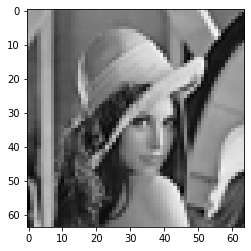

Kernel:


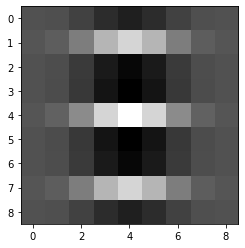

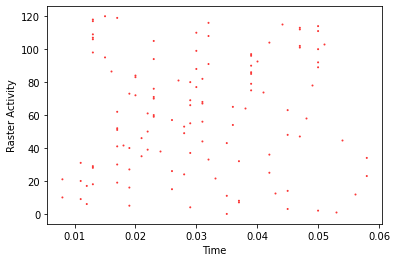

In [71]:
kernel = gabor(lambda_=3, theta=np.pi, sigma=4, gamma=3, size=9)
simulate_convolutional_and_pooling_connections(0.1, kernel, 5, 5)

### Analysis of experiment 1

| kernel | $\lambda$ | $\theta$ | $\sigma$ | $\gamma$ | size |
| ------ | --------- | -------- | -------- | -------- | ---- |
| Gabor  |      3    |  $\pi$   |    4     |     3    |   9  |

* Pooling size: 5
* Pooling stride: 5

Here we have added a pooling connection with size 5 and stride 5 which will lead to information compression. all other interpretations are the same as experiment 1 without pooling connection, we can see here that the overall shape of raster plot here is the same as the raster plot of experiment 1 without pooling connection but with less neurons.

### Experiment 2

Image:


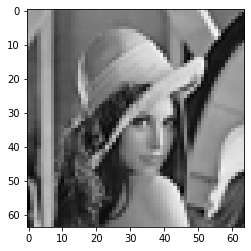

Kernel:


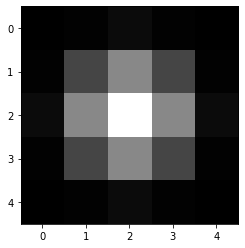

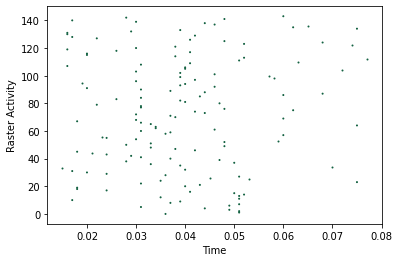

In [73]:
kernel = DoG(std_1=1, std_2=3, size=5)
simulate_convolutional_and_pooling_connections(0.1, kernel, 5, 5)

### Analysis of experiment 2

| kernel | $\sigma_1$ | $\sigma_2$ | size |
| ------ | ---------- | ---------- | ---- |
|   DoG  |      1     |     3      |  5   |

* Pooling size: 5
* Pooling stride: 5

All things are the same as experiment 2 without pooling connection except that here with pooling we have information compression.

### Summary

With convolutional connections we can extract complex features of an input with the help of diffrent kernels and with pooling connections we can have information compression from previous layers.